# A4 Classification of Hand-Drawn Digits

* A4.1: *Now includes `optimizers.py`*
* A4.2: *Added `A4grader.zip` and extra credit.*

In this assignment, you will define a new class named `NeuralNetworkClassifier` that extends the `NeuralNetwork` class provided here and is the solution to Assignment A2.  You will use `NeuralNetworkClassifier` to train a classifier of hand-drawn digits.

You will also define the function `confusion_matrix`.

## `NeuralNetwork` class

In [0]:
import matplotlib.pyplot as plt
import math

The following code cell will write its contents to `optimizers.py` so the `import optimizers` statement in the code cell after it will work correctly.

In [0]:
%%writefile optimizers.py
import numpy as np

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing m, v, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1
        self.beta2t = 1

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

if __name__ == '__main__':

    import matplotlib.pyplot as plt
    plt.ion()

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin],
                  n_epochs=500, learning_rate=0.1)

    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin],
                   n_epochs=500, learning_rate=0.1)
    
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

Overwriting optimizers.py


In [0]:
import numpy as np
import optimizers
import sys  # for sys.float_info.epsilon

######################################################################
## class NeuralNetwork()
######################################################################

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

    
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)
        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views

    def __repr__(self):
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs}, \'{self.activation_function}\')'

    def __str__(self):
        result = self.__repr__()
        if len(self.error_trace) > 0:
            return self.__repr__() + f' trained for {len(self.error_trace)} epochs, final training error {self.error_trace[-1]:.4f}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        optimizer = optimizers.Optimizers(self.all_weights)
        if len(self.Tstds) == 1:
            error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0]
        else:
            error_convert_f = lambda err: np.sqrt(err)[0] 
            

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace
        return self

    def relu(self, s):
        s[s < 0] = 0
        return s

    def grad_relu(self, s):
        return (s > 0).astype(int)
    
    def forward_pass(self, X):
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

 
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    def gradient_f(self, X, T):
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients
    def use(self, X):
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = Ys[-1]
        return Y * self.Tstds + self.Tmeans

Adam: Epoch 25 Error=0.24045
Adam: Epoch 50 Error=0.22242
Adam: Epoch 75 Error=0.20345
Adam: Epoch 100 Error=0.18067
Adam: Epoch 125 Error=0.14507
Adam: Epoch 150 Error=0.10186
Adam: Epoch 175 Error=0.07442
Adam: Epoch 200 Error=0.06129
Adam: Epoch 225 Error=0.05355
Adam: Epoch 250 Error=0.04759


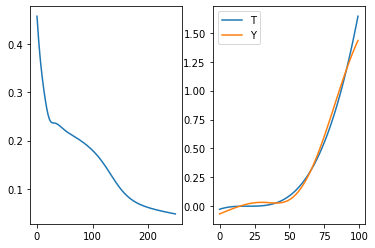

In [0]:
X = np.arange(100).reshape((-1, 1))
T = (X - 20) ** 3 / 300000

hiddens = [10]
nnet = NeuralNetwork(X.shape[1], hiddens, T.shape[1])
nnet.train(X, T, 250, 0.01, method='adam')

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)

plt.subplot(1, 2, 2)
plt.plot(T, label='T')
plt.plot(nnet.use(X), label='Y')
plt.legend()

## Your `NeuralNetworkClassifier` class

Complete the following definition of `NeuralNetworkClassifier` as discussed in class. You will need to override the functions

* `train`
* `error_f`
* `gradient_f`
* `use`

and define the following new functions

* `makeIndicatorVars`
* `softmax`

In [0]:
class NeuralNetworkClassifier(NeuralNetwork):
    def standardizeT(self, T):
        return T
    def unstandardizeT(self, Ts):
        return Ts

    def makeIndicatorVars(self, T):
        if T.ndim == 1:
            T = T.reshape((-1,1))    
        return (T == np.unique(T)).astype(int)

    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        probs = self.softmax(Ys[-1])
        LL = T * np.log(probs + sys.float_info.epsilon)
        neg_mean_LL = -np.mean(LL)
        return neg_mean_LL


    
    
    def gradient_f(self, X, T):
        error = ( T - self.softmax(self.Ys[-1]) )
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients
    
  
    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        self.classes=np.unique(T)
        X=np.array(X,dtype=np.float)
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1
        T = self.makeIndicatorVars(T)
        X = (X - self.Xmeans) / self.Xstds
        T = self.standardizeT(T)
        if T.ndim == 1:
            T = T.reshape((-1, 1))

        
        
        optimizer = optimizers.Optimizers(self.all_weights)
        
        def error_convert_f(neg_mean_LL):
            return np.exp( -neg_mean_LL )

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)


        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace


    def use(self, X):
       
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        W = self.softmax(Ys[-1])
        d = np.argmax(W, axis = 1)
        Y = self.classes[d].reshape(-1,1)
       # Y = Y *self.Tstds + self.Tmeans
        # Unstandardize output Y before returning it
        return  Y, W
    
    def softmax(self, Y):
        Y1 = np.exp(Y)  
        denom = np.sum(Y1, axis=1).reshape((-1, 1))
        Y2 = Y1 / denom
        return Y2

Adam: Epoch 25 Error=0.24770
Adam: Epoch 50 Error=0.22430
Adam: Epoch 75 Error=0.20379
Adam: Epoch 100 Error=0.17634
Adam: Epoch 125 Error=0.14123
Adam: Epoch 150 Error=0.10550
Adam: Epoch 175 Error=0.07652
Adam: Epoch 200 Error=0.05637
Adam: Epoch 225 Error=0.04340
Adam: Epoch 250 Error=0.03506


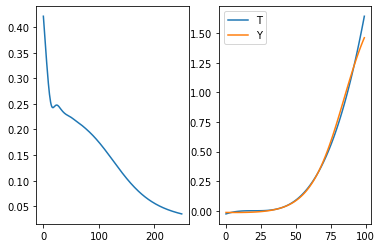

In [0]:
X = np.arange(100).reshape((-1, 1))
T = (X - 20) ** 3 / 300000

hiddens = [10]
nnet = NeuralNetwork(X.shape[1], hiddens, T.shape[1])
nnet.train(X, T, 250, 0.01, method='adam')

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)

plt.subplot(1, 2, 2)
plt.plot(T, label='T')
plt.plot(nnet.use(X), label='Y')
plt.legend()

Here is a simple test of your new class.  For inputs from 0 to 100, classify values less than or equal to 25 as Class Label 25, greater than 25 and less than or equal to 75 as Class Label 75, and greater than 75 as Class Label 100. 

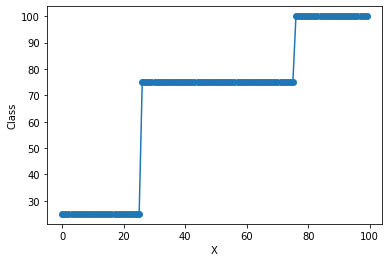

In [0]:
X = np.arange(100).reshape((-1, 1))
T = X.copy()
T[T <= 25] = 25
T[np.logical_and(25 < T, T <= 75)] = 75
T[T > 75] = 100

plt.plot(X, T, 'o-')
plt.xlabel('X')
plt.ylabel('Class');

Adam: Epoch 20 Error=0.77385
Adam: Epoch 40 Error=0.84451
Adam: Epoch 60 Error=0.89328
Adam: Epoch 80 Error=0.92506
Adam: Epoch 100 Error=0.94325
Adam: Epoch 120 Error=0.95386
Adam: Epoch 140 Error=0.96064
Adam: Epoch 160 Error=0.96538
Adam: Epoch 180 Error=0.96892
Adam: Epoch 200 Error=0.97170


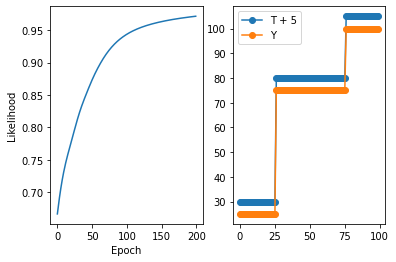

In [0]:
hiddens = [10]
nnet = NeuralNetworkClassifier(X.shape[1], hiddens, len(np.unique(T)))
nnet.train(X, T, 200, 0.01, method='adam', verbose=True)

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)
plt.xlabel('Epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T + 5, 'o-', label='T + 5')  # to see, when predicted overlap T very closely
plt.plot(nnet.use(X)[0], 'o-', label='Y')
plt.legend()

## Now for the Hand-Draw Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz`. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [0]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [0]:
Ttrain[:10]

array([[5],
       [0],
       [4],
       [1],
       [9],
       [2],
       [1],
       [3],
       [1],
       [4]])

Those must be the digits.  What the heck is in those 784 columns in the input matrices?

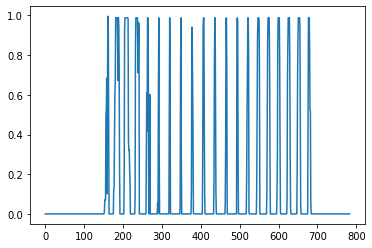

In [0]:
plt.plot(Xtrain[0, :]);

Well, values between 0 and 1.  That doesn't help much.  These are actually intensity values for 784 pixels in an image.

How can we rearrange these values into an image to be displayed?  We must first figure out how many columns and rows the image would have.  Perhaps the image is a square image, with equal numbers of rows and columns.

In [0]:
import math
math.sqrt(784)

28.0

Ah, cool.

In [0]:
28 * 28

784

Ok Let's reshape it and look at the numbers.

In [0]:
image0 = Xtrain[0, :]
image0 = image0.reshape(28, 28)
image0

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

Not that helpful.  Ok, let's use `matplotlib` to make an image display.

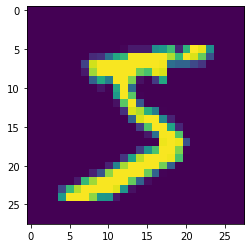

In [0]:
plt.imshow(image0);

Humm.  Try a grayscale color map.

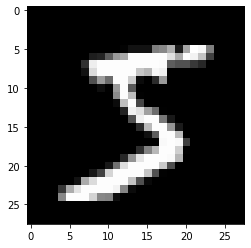

In [0]:
plt.imshow(image0, cmap='gray');

With a little more work, we can make it look like a pencil drawing.

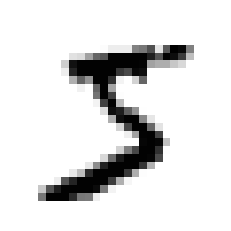

In [0]:
plt.imshow(-image0, cmap='gray')  # notice the negative sign
plt.axis('off');

Looks like a 5.  What class label is associated with this image?

In [0]:
Ttrain[0]

array([5])

Okay.  Makes sense.  Let's look at the first 100 images and their labels, as plot titles.

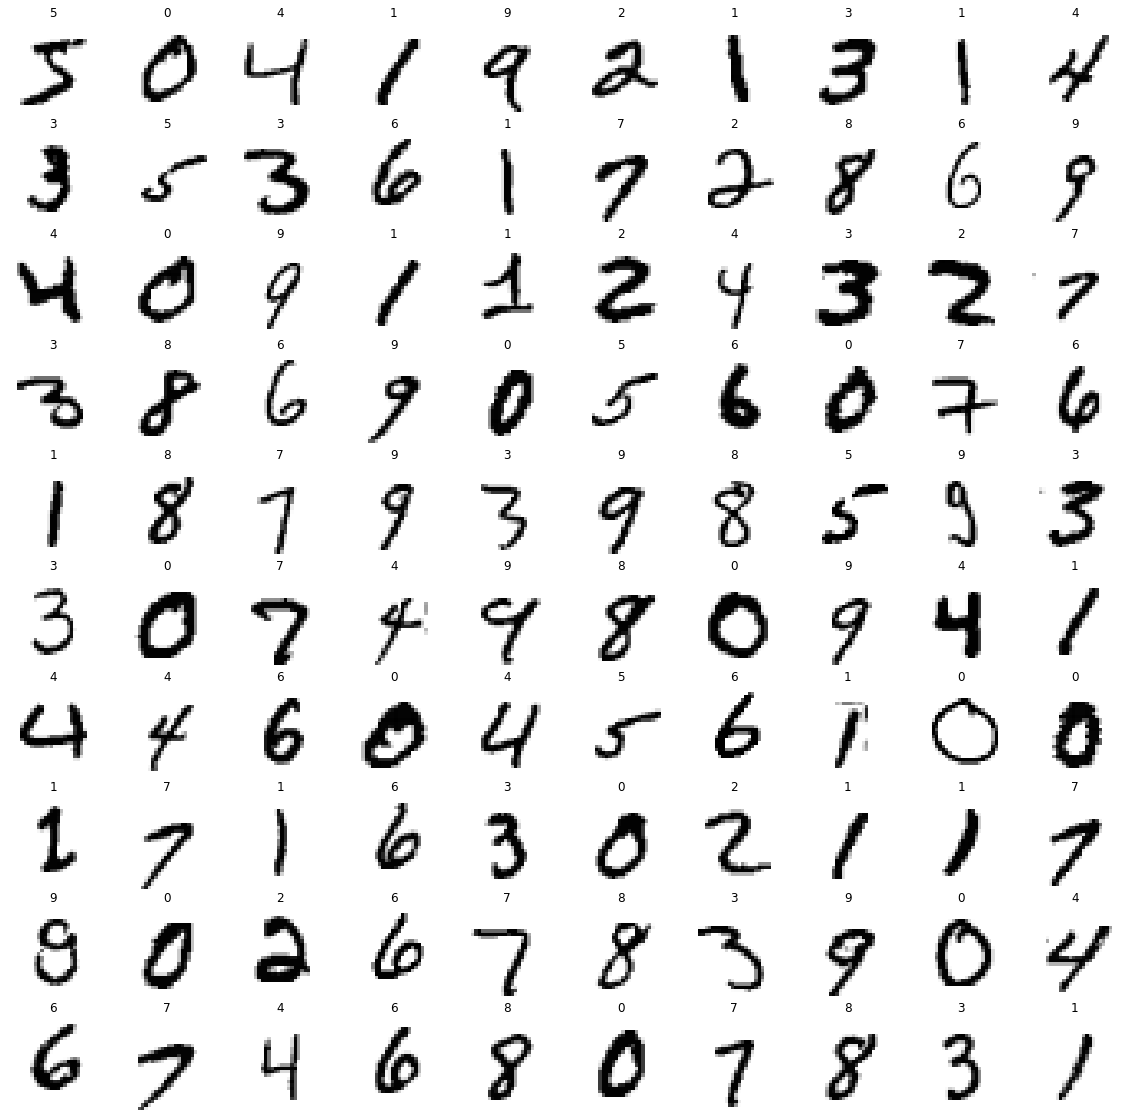

In [0]:
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(-Xtrain[i, :].reshape(28, 28), cmap='gray')
    plt.title(Ttrain[i, 0])
    plt.axis('off');

Okay.  We are ready to try to classify, right?

First we should check the proportions of each digit in the given data partitions.

In [0]:
classes = np.arange(10)
(Ttrain == classes).shape

(50000, 10)

In [0]:
(Ttrain == classes).sum(axis=0)

array([4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988])

In [0]:
(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]

array([0.09864, 0.11356, 0.09936, 0.10202, 0.09718, 0.09012, 0.09902,
       0.1035 , 0.09684, 0.09976])

In [0]:
['Ttrain', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]]

['Ttrain',
 0.09864,
 0.11356,
 0.09936,
 0.10202,
 0.09718,
 0.09012,
 0.09902,
 0.1035,
 0.09684,
 0.09976]

In [0]:
import pandas

result = []
result.append(['Train', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]])
result.append(['Tval', *(Tval == classes).sum(axis=0) / Tval.shape[0]])
result.append(['Ttest', *(Ttest == classes).sum(axis=0) / Ttest.shape[0]])
pandas.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,10
0,Train,0.09864,0.11356,0.09936,0.10202,0.09718,0.09012,0.09902,0.1035,0.09684,0.09976
1,Tval,0.09910,0.10640,0.09900,0.10300,0.09830,0.09150,0.09670,0.1090,0.10090,0.09610
2,Ttest,0.09800,0.11350,0.10320,0.10100,0.09820,0.08920,0.09580,0.1028,0.09740,0.10090


All very close to 0.1. Super.

Time for our first experiment.  Let's train a small neural net with 5 hidden units in one layer for a small number of epochs using Adam.

In [0]:
n_epochs = 100
learning_rate = 0.01

np.random.seed(142)

nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)

Adam: Epoch 10 Error=0.82887
Adam: Epoch 20 Error=0.85170
Adam: Epoch 30 Error=0.87229
Adam: Epoch 40 Error=0.88913
Adam: Epoch 50 Error=0.90202
Adam: Epoch 60 Error=0.91179
Adam: Epoch 70 Error=0.91932
Adam: Epoch 80 Error=0.92541
Adam: Epoch 90 Error=0.93041
Adam: Epoch 100 Error=0.93448


In [0]:
print(nnet)  # uses the __str__ method

NeuralNetworkClassifier(784, [5], 10, 'tanh') trained for 100 epochs, final training error 0.9345


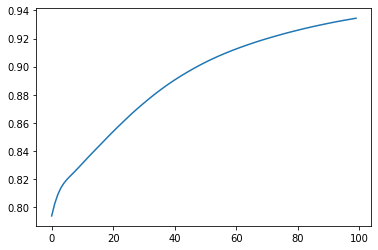

In [0]:
plt.plot(nnet.error_trace);

Now it is time for you to run some longer experiments.  You must write the code to do the following steps:

1. For each of at least five different hidden layer structures

    1. Train a network for 500 epochs.
    1. Collect percent of samples correctly classified in the given train, validate, and test partitions.

2. Create a `pandas.DataFrame` with these results and with column headings `('Hidden Layers', 'Train', 'Validate', 'Test', 'Time')` where `'Time'` is the number of seconds required to train each network.

3. Retrain a network using the best hidden layer structure, judged by the percent correct on the validation set.
4. Use this network to find several images in the test set for which the network's probability of the correct class is the closest to zero, meaning images for which your network does the worst.  Draw these images and discuss why your network might not be doing well for those images.

In [0]:
import time

In [0]:
def run_experiment(Xtrain, Ttrain, Xtest, Ttest, Xvalidate, Tvalidate, n_hidden_units_per_layer_choices):
    epochs = 500
    rate = 0.01
    results = []
    for nh in n_hidden_units_per_layer_choices:
        start_time = time.time()        
        nnet = NeuralNetworkClassifier(Xtrain.shape[1], nh, len(np.unique(Ttrain)))
        nnet.train(Xtrain, Ttrain, epochs, rate, method='adam')
        elapsed_time = time.time() - start_time
        print (elapsed_time)
        Train_classes, Train_probs = nnet.use(Xtrain)
        Test_classes, Test_probs = nnet.use(Xtest)
        Validate_classes, Validate_probs = nnet.use(Xvalidate)
        Train_percent = np.mean(Train_classes == Ttrain) * 100
        Test_percent = np.mean(Test_classes == Ttest) * 100 
        Validate_percent = np.mean(Validate_classes == Tval) * 100 
        results.append([nh, Train_percent, Test_percent, Validate_percent, elapsed_time])
        df = pandas.DataFrame(results, columns=('Hidden Layers', 'Train', 'Validate', 'Test', 'Time'))
    return df

In [0]:
result = run_experiment(Xtrain, Ttrain, Xtest, Ttest, Xval, Tval, 
                   n_hidden_units_per_layer_choices=[[0], [20], [50, 20], [50,50],[50, 50, 20]]);
                   

Adam: Epoch 50 Error=0.97328
Adam: Epoch 100 Error=0.97618
Adam: Epoch 150 Error=0.97719
Adam: Epoch 200 Error=0.97783
Adam: Epoch 250 Error=0.97827
Adam: Epoch 300 Error=0.97859
Adam: Epoch 350 Error=0.97885
Adam: Epoch 400 Error=0.97905
Adam: Epoch 450 Error=0.97921
Adam: Epoch 500 Error=0.97935
245.552809715271
Adam: Epoch 50 Error=0.97115
Adam: Epoch 100 Error=0.98013
Adam: Epoch 150 Error=0.98393
Adam: Epoch 200 Error=0.98631
Adam: Epoch 250 Error=0.98797
Adam: Epoch 300 Error=0.98916
Adam: Epoch 350 Error=0.99008
Adam: Epoch 400 Error=0.99081
Adam: Epoch 450 Error=0.99137
Adam: Epoch 500 Error=0.99187
302.62653374671936
Adam: Epoch 50 Error=0.97408
Adam: Epoch 100 Error=0.99004
Adam: Epoch 150 Error=0.99475
Adam: Epoch 200 Error=0.99673
Adam: Epoch 250 Error=0.99777
Adam: Epoch 300 Error=0.99834
Adam: Epoch 350 Error=0.99870
Adam: Epoch 400 Error=0.99896
Adam: Epoch 450 Error=0.99913
Adam: Epoch 500 Error=0.99926
465.12486934661865
Adam: Epoch 50 Error=0.98070
Adam: Epoch 100 Err

In [0]:
n_epochs = 500
learning_rate = 0.01

#np.random.seed(142)

nnet = NeuralNetworkClassifier(Xtrain.shape[1], [50,50], len(classes))
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)

Adam: Epoch 50 Error=0.98185
Adam: Epoch 100 Error=0.99323
Adam: Epoch 150 Error=0.99679
Adam: Epoch 200 Error=0.99823
Adam: Epoch 250 Error=0.99893
Adam: Epoch 300 Error=0.99929
Adam: Epoch 350 Error=0.99949
Adam: Epoch 400 Error=0.99962
Adam: Epoch 450 Error=0.99971
Adam: Epoch 500 Error=0.99977


## `confusion_matrix`

Now, write a function named `confusion_matrix` that returns a confusion matrix for any classification problem, returned as a `pandas.DataFrame` as shown in Lecture Notes 12.  It must require two arguments, the predicted classes for each sample and the true classes for each sample.  Here is an example.

In [0]:
result

,Hidden Layers,Train,Validate,Test,Time
0,[0],94.166,92.35,92.57,245.552810
1,[20],98.148,92.10,92.35,302.626534
2,"[50, 20]",99.908,93.49,93.56,465.124869
3,"[50, 50]",99.984,93.93,94.34,518.938425
4,"[50, 50, 20]",99.942,92.81,92.99,541.875699


The best configuration is when the number of hidden layer is [50,50]. The validation accuracy in this case is 93.93 %..
When more layers were added the validation accuracy decreased due to overfitting.  

In [0]:
def confusion_matrix(Y_classes, T):
    table = []
    for true_class in np.unique(Y_classes):
        row = []
        for predicted_class in np.unique(Y_classes):
            row.append(100 * np.mean(Y_classes[T == true_class] == predicted_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=np.unique(Y_classes), columns=np.unique(Y_classes))
    return conf_matrix

In [0]:
Y_classes, Y_probs = nnet.use(Xtest)
confusion_matrix(Y_classes, Ttest)

,0,1,2,3,4,5,6,7,8,9
0,89.795918,0.204082,1.530612,0.000000,1.428571,1.020408,3.877551,1.326531,0.204082,0.612245
1,0.176211,94.625551,1.321586,1.233480,0.264317,0.176211,0.352423,0.088106,1.762115,0.000000
2,1.162791,1.550388,85.658915,2.228682,1.453488,0.387597,3.294574,0.872093,3.100775,0.290698
3,0.000000,0.792079,8.415842,77.821782,0.693069,3.663366,2.475248,1.683168,3.465347,0.990099
4,0.814664,1.120163,1.120163,0.305499,82.281059,1.731161,0.610998,1.018330,0.407332,10.590631
5,2.690583,0.336323,1.233184,3.139013,1.793722,74.887892,4.708520,0.896861,6.726457,3.587444
6,3.131524,0.208768,3.027140,0.626305,0.521921,5.323591,84.237996,2.400835,0.313152,0.208768
7,1.167315,3.015564,1.361868,0.875486,2.918288,0.000000,0.583658,84.241245,0.000000,5.836576
8,1.026694,1.848049,0.821355,6.262834,0.513347,7.802875,1.129363,1.437372,76.694045,2.464066
9,2.081269,1.288404,0.000000,0.991080,5.748266,1.189296,0.000000,3.567889,1.090188,84.043608


In [0]:
threshold= 0.05
predict_class, probab = nnet.use(Xtest)
pred = predict_class, probab = nnet.use(Xtest)
num = pred [pred < threshold]
num1 = np.shape(num)[0]
plt.figure(figsize = (28,28))
for j in range(0,num1):
  f = np.where(pred == num[j])
  f = f[0][0]
  plt.subplot(10, 10, j+1)
  plt.imshow(-Xtest[f, : ].reshape(28,28),cmap ='gray')
  plt.title(" P:%d" % Y_classes [f ,0] + "A: %d"% Ttest[f])
  plt.axis('off');

TypeError: ignored

## Grading and Check-In
Download [A4grader.zip](https://www.cs.colostate.edu/~anderson/cs445/notebooks/A4grader.zip) and extract A4grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A4.ipynb.  

When ready, submit your notebook via the A4 link in our class Canvas web page.

In [1]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Chakraborty-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.forward_pass.__func__ == nn_class.forward_pass.__func__


--- 10/10 points.  Function NeuralNetwork.forward_pass is correctly not overridden in NeuralNetworkClassifier.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.train.__func__ != nn_class.train.__func__


--- 10/10 points.  Function NeuralNetwork.train is correctly overridden in NeuralNetworkClassifier.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.use.__func__ != nn_class.use.__func__


--- 10/10 points.  Function NeuralNetwork.use is correctly overridden in 

## Extra Credit
Earn 1 extra credit point on this assignment by doing the following.

1. Combine the train, validate, and test partitions loaded from the MNIST data file into two matrices, `X` and `T`. 
2. Using `adam` , `relu` and just one value of `learning_rate` and `n_epochs`, compare several hidden layer architectures. Do so by applying our `generate_k_fold_cross_validation_sets` function as defined in Lecture Notes 12 which forms stratified partitioning, for use in classification problems, to your `X` and `T` matrices using `n_fold` of 3.
3. Show results and discuss which architectures you find works the best, and how you determined this.